### Customer Spending Profile 
we categorize each customer as either low, medium, or high spending according to their average expense

In [25]:
import pandas as pd
import numpy as np

LABEL_FEATURE = "tot_sales"

indicators = pd.read_csv('../dataset/indicators_no_outlier.csv', index_col="CustomerID")

In [2]:
indicators.describe()

,Entropy,i,iu,imax,tot_sales,mean_sales
count,4183.000000,4183.000000,4183.000000,4183.000000,4183.000000,4183.000000
mean,0.883279,761.545781,54.277552,209.982070,215.797343,62.086895
std,0.833093,1151.855864,56.299433,198.147531,272.329634,48.291224
min,-0.000000,1.000000,1.000000,1.000000,0.170000,0.170000
25%,-0.000000,153.000000,15.000000,80.000000,49.965000,27.682500
50%,0.693147,356.000000,34.000000,150.000000,118.950000,49.785000
75%,1.386294,886.500000,74.000000,268.000000,266.235000,84.280000
max,3.550250,13162.000000,315.000000,1440.000000,2464.840000,318.190000


In [3]:
# first try with tot_sales
def label_by_quantiles(label_feature, quantiles):
    if (label_feature < quantiles[10]):
        return "low"
    elif (label_feature < quantiles[15]):
        return "medium"
    else:
        return "high"

def set_label(labelFeature):
    quantiles = []
    
    for i in range(0, 100, 5):
        quantile = indicators[labelFeature].quantile(i/100)
        quantiles.append(quantile)
        #print(f"{i}% quantile: ".format(i)+str(round(quantile, 2)))
        
    df = indicators.copy(deep=True)
    df["spending_profile"] = df[LABEL_FEATURE].apply(lambda x : label_by_quantiles(x, quantiles))
    
    return df

In [4]:
df = set_label(LABEL_FEATURE)
print(df)

             Entropy     i   iu  imax  tot_sales  mean_sales spending_profile
CustomerID                                                                   
12347       1.945910  2458  103   319     481.21   68.744286             high
12348       1.386294  2341   22  1254     178.71   44.677500           medium
12350      -0.000000   197   17   197      65.30   65.300000              low
12352       2.079442   473   59    98    1337.42  167.177500             high
12353      -0.000000    20    4    20      24.30   24.300000              low
...              ...   ...  ...   ...        ...         ...              ...
18280      -0.000000    45   10    45      47.65   47.650000              low
18281      -0.000000    54    7    54      39.36   39.360000              low
18282       0.693147   103   12    75      62.39   31.195000              low
18283       2.566599  1357  263    61    1174.33   73.395625             high
18287       1.098612  1586   59   488     104.55   34.850000    

### Computing spending profile label

we begin by plotting the distribution and the quantiles for tot_sales, the feature from which we want to compute our label

<AxesSubplot:ylabel='Frequency'>

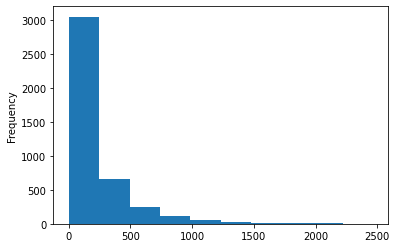

In [5]:
df[LABEL_FEATURE].plot.hist()

We drop the column we used to compute our label in order to proceed with classification

In [6]:
df = df.drop(LABEL_FEATURE, axis=1)

## Discretizing the label

In [7]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [8]:
#discretize the variable relationship, sex, occupation, marital-status, native-country, race
variables = ['spending_profile']
df = discretize_data(df, variables)

## Splitting the dataset

In [9]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
from sklearn.model_selection import train_test_split
label = df.pop('spending_profile')
train_set, test_set, train_label, test_label = train_test_split(df, label, stratify =label, test_size=0.5)

# discretized sets
train_set_discretized = train_set.copy(deep=True)
test_set_discretized = test_set.copy(deep=True)

train_set = train_set.drop('spending_profile_num', axis=1)
test_set = test_set.drop('spending_profile_num', axis=1)

## Classifier Collection

In [10]:
#metrics computed on the test set
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_validate
import statistics 

def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=["low", "medium", "high"]))

def classification(clf, parameters=None, pscore=True):
    
    if parameters is None:
        classifier = clf
    else:
        classifier = clf(**parameters)
        
    classifier = classifier.fit(train_set, train_label)
    test_pred_clf = classifier.predict(test_set)
    train_pred_clf = classifier.predict(train_set)
    if pscore is True:
        print("============== score report ==============")
        report_scores(test_label, test_pred_clf)
        print("============== accuracy report ==============\n")
        accuracy_on_train(test_pred_clf,train_pred_clf)
        print("\n============== cross report ==============\n")
        clf_cross_validate(classifier)
    
    return classifier

def optimized_hyperparameters(clf, params_range, pscore=True):
    
    rndsearch = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=50, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
    
    #run the rndsearch
    rndsearch.fit(train_set, train_label)
    
    if pscore is True:
        print('Mean and std of this setting ', 
              rndsearch.cv_results_['mean_test_score'][0], 
              rndsearch.cv_results_['std_test_score'][0])
        
    return rndsearch.cv_results_['params'][0]

#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
def accuracy_on_train(test_pred_clf,train_pred_clf):
    print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_clf))
    print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_clf))
    print('Precision train set ', metrics.precision_score(train_label, train_pred_clf, average='weighted'))
    print('Recall train set ', metrics.recall_score(train_label, train_pred_clf, average='weighted'))
    print('F1 score train set ', metrics.f1_score(train_label, train_pred_clf, average='weighted'))
    print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_clf))
    

#cross validation
#the score array for test/train scores on each cv split
#the time for fitting/scoring the estimator on the train set for each cv split
def clf_cross_validate(clf):
    scores = cross_validate(clf, train_set, train_label, cv=3, return_train_score= True)
    print('Fit time ', statistics.mean(scores['fit_time']))
    print('Score time ', statistics.mean(scores['score_time']))
    print('Test score ', statistics.mean(scores['test_score']))
    print('Train score ', statistics.mean(scores['train_score']))

## Classification with Decision Tree

In [11]:
from sklearn import tree

param_dict = {"min_samples_split": 3,
              "min_samples_leaf": 4,
              "max_depth": 10,
              "criterion": "gini",
              "splitter": "best"}

dt = classification(tree.DecisionTreeClassifier,param_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.93      0.94      0.93       523
      medium       0.98      0.98      0.98      1046
        high       0.90      0.88      0.89       523

    accuracy                           0.95      2092
   macro avg       0.94      0.93      0.94      2092
weighted avg       0.95      0.95      0.95      2092

============== accuracy report ==============

Accuracy train set  0.9746532759445241
Accuracy test set  0.9469407265774379
Precision train set  0.9744976117156073
Recall train set  0.9746532759445241
F1 score train set  0.9745189140646016
Support train set  (array([0.96558317, 0.98582231, 0.96078431]), array([0.96558317, 0.99808612, 0.93690249]), array([0.96558317, 0.99191631, 0.94869313]), array([ 523, 1045,  523]))

============== cross report ==============

Fit time  0.007044235865275065
Score time  0.0035243829091389975
Test score  0.9349593495934959
Train score  

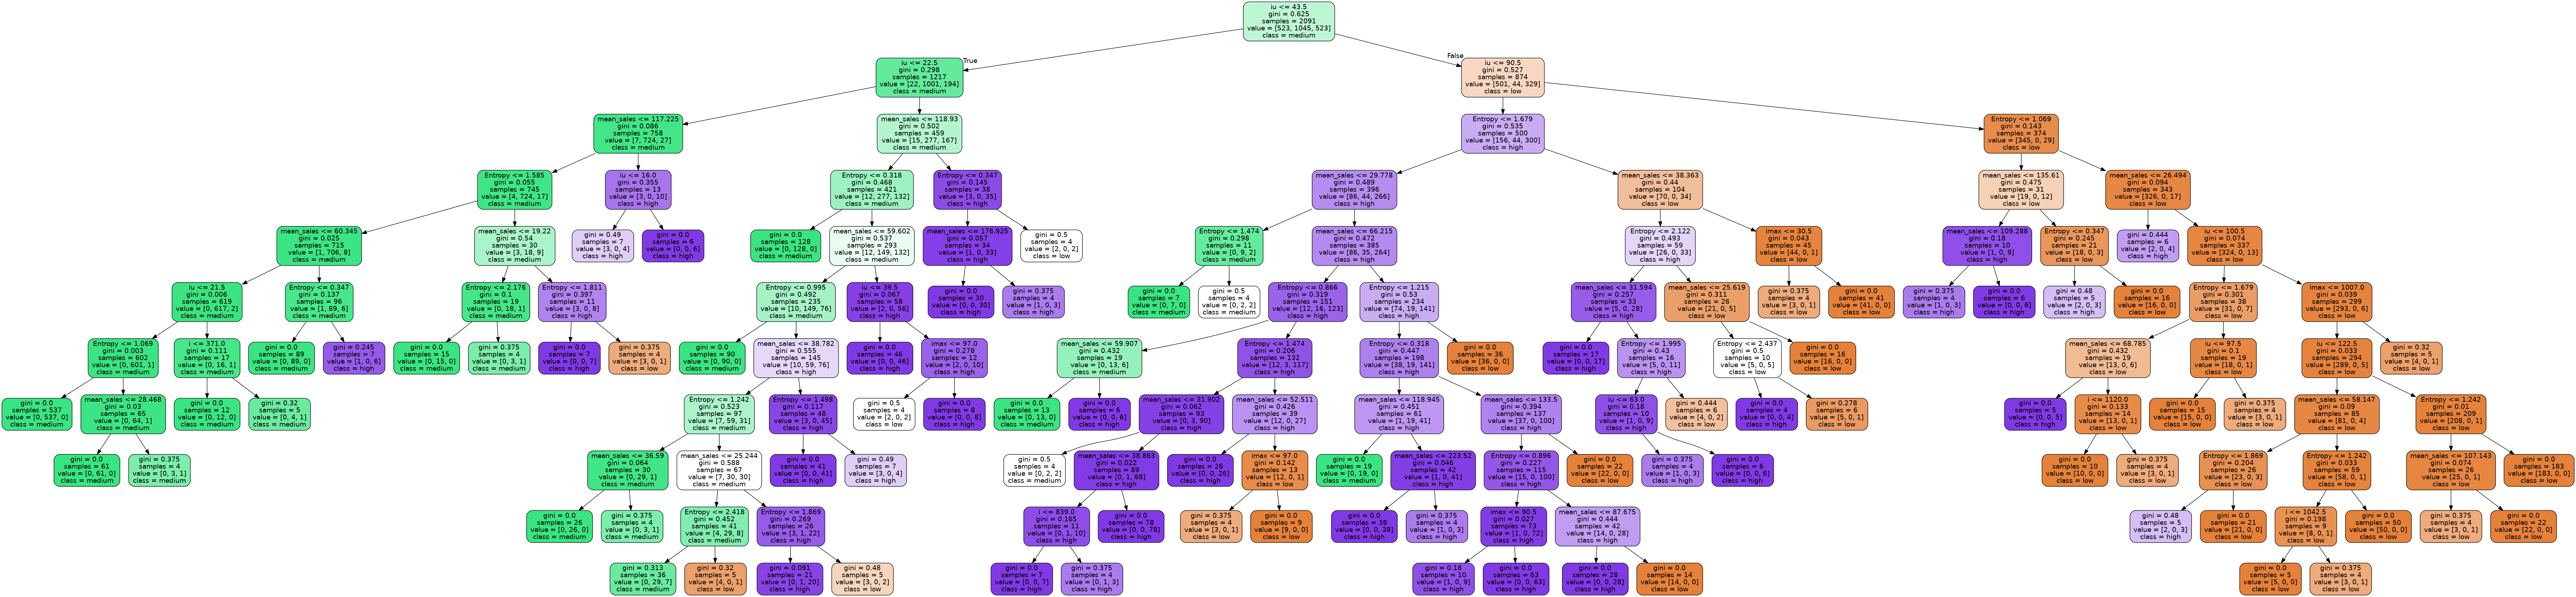

In [12]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['low', 'medium', "high"],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [13]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

### Decision Tree evaluation

In [14]:
#compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[ 491,    0,   32],
       [   0, 1028,   18],
       [  37,   24,  462]])

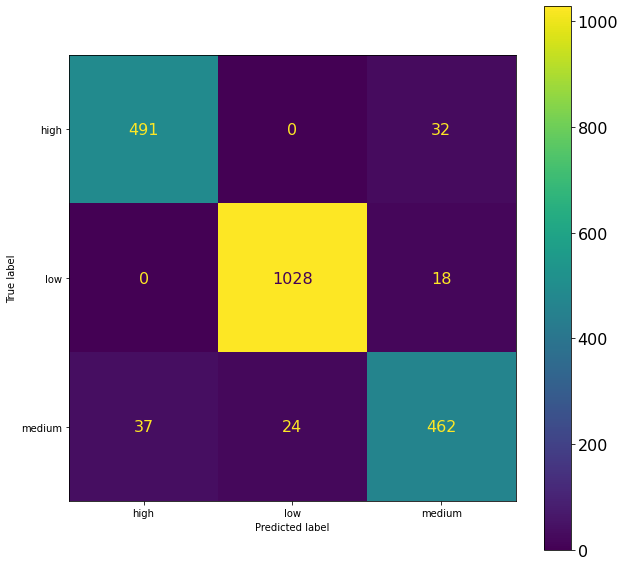

In [15]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16, "axes.labelsize" : 14})


plot_confusion_matrix(dt, test_set, test_label, ax=ax)
plt.show() 

## Classification with Naive Bayes

In [16]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB

gnb = classification(GaussianNB())

============== score report ==============
              precision    recall  f1-score   support

         low       0.90      0.74      0.81       523
      medium       0.90      0.90      0.90      1046
        high       0.63      0.75      0.68       523

    accuracy                           0.82      2092
   macro avg       0.81      0.79      0.80      2092
weighted avg       0.83      0.82      0.82      2092

============== accuracy report ==============

Accuracy train set  0.8101386896221904
Accuracy test set  0.8197896749521989
Precision train set  0.8240113561580562
Recall train set  0.8101386896221904
F1 score train set  0.8130518828506926
Support train set  (array([0.88221154, 0.90143541, 0.61111111]), array([0.70172084, 0.90143541, 0.73613767]), array([0.78168264, 0.90143541, 0.66782307]), array([ 523, 1045,  523]))

============== cross report ==============

Fit time  0.00466148058573405
Score time  0.0031975110371907554
Test score  0.8134863701578192
Train score  0

## Classification with Random Forest

In [17]:
#define and fit a random forest
from sklearn.ensemble import RandomForestClassifier

params_dict = {
    'n_estimators' : 30, 
    'criterion' : 'gini',
    'max_features' : 3,
    'max_depth' : 4, 
    'min_samples_split' : 2,
    'min_samples_leaf' : 8,
    'bootstrap' : True
}

rf = classification(RandomForestClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.90      0.83      0.86       523
      medium       0.93      0.93      0.93      1046
        high       0.73      0.77      0.75       523

    accuracy                           0.87      2092
   macro avg       0.85      0.84      0.85      2092
weighted avg       0.87      0.87      0.87      2092

============== accuracy report ==============

Accuracy train set  0.8823529411764706
Accuracy test set  0.8671128107074569
Precision train set  0.885360204154919
Recall train set  0.8823529411764706
F1 score train set  0.8826133808897706
Support train set  (array([0.91938998, 0.93451824, 0.75310835]), array([0.80688337, 0.95598086, 0.81070746]), array([0.85947047, 0.94512772, 0.78084715]), array([ 523, 1045,  523]))

============== cross report ==============

Fit time  0.07236655553181966
Score time  0.007539510726928711
Test score  0.860832137733142
Train score  0.88

### Volendo il random forest può essere "migliorato" e tunato in vari modi. Ne vale la pena? Forse no. Guarda il notebook adult_classification

The performance is may slightly worse for the randomized search, and is likely due to a noise effect and would not carry over to a held-out test set.

Note that in practice, one would not search over this many different parameters simultaneously using grid search, but pick only the ones deemed most important.

In [18]:
#to find the best set of parameter setting, we can run a grid search
from scipy.stats import randint as sp_randint

#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}]}

#define the model
clf = RandomForestClassifier(n_estimators=30)
rs = optimized_hyperparameters(clf, param_dist)
                               
optimized_rf = classification(RandomForestClassifier,rs)

Mean and std of this setting  0.9139132817942013 0.01686484152315128
============== score report ==============
              precision    recall  f1-score   support

         low       0.92      0.90      0.91       523
      medium       0.98      0.92      0.95      1046
        high       0.78      0.89      0.83       523

    accuracy                           0.91      2092
   macro avg       0.89      0.90      0.90      2092
weighted avg       0.92      0.91      0.91      2092

============== accuracy report ==============

Accuracy train set  0.9335246293639407
Accuracy test set  0.9086998087954111
Precision train set  0.938089716550581
Recall train set  0.9335246293639407
F1 score train set  0.9347329641073155
Support train set  (array([0.95219124, 0.98601399, 0.82823129]), array([0.91395793, 0.94449761, 0.93116635]), array([0.93268293, 0.96480938, 0.87668767]), array([ 523, 1045,  523]))

============== cross report ==============

Fit time  0.3913756211598714
Score time  

## Che è sta roba? perché c'è sto terzo caso? bho!

In [19]:
param_dict = {
    'n_estimators':30, 
    'criterion':'gini',
    'max_features':3,
    'max_depth':6, 
    'min_samples_split':32,
    'min_samples_leaf':10,
    'bootstrap':False,
    'class_weight':'balanced'
}
rf = classification(RandomForestClassifier,param_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.91      0.88      0.90       523
      medium       0.99      0.94      0.96      1046
        high       0.79      0.89      0.84       523

    accuracy                           0.91      2092
   macro avg       0.90      0.90      0.90      2092
weighted avg       0.92      0.91      0.92      2092

============== accuracy report ==============

Accuracy train set  0.945480631276901
Accuracy test set  0.9134799235181644
Precision train set  0.9486319215088399
Recall train set  0.945480631276901
F1 score train set  0.9462858753305289
Support train set  (array([0.954     , 0.99309665, 0.85441941]), array([0.91204589, 0.96363636, 0.94263862]), array([0.93255132, 0.97814473, 0.89636364]), array([ 523, 1045,  523]))

============== cross report ==============

Fit time  0.09011236826578777
Score time  0.00768287976582845
Test score  0.9053084648493543
Train score  0.930

## AdaBoost

In [20]:
from sklearn.ensemble import AdaBoostClassifier

params_dict = {
    'n_estimators' : 100,
    'random_state' : 0
}

ada = classification(AdaBoostClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.99      0.80      0.88       523
      medium       0.99      0.85      0.92      1046
        high       0.66      0.98      0.79       523

    accuracy                           0.87      2092
   macro avg       0.88      0.88      0.86      2092
weighted avg       0.91      0.87      0.88      2092

============== accuracy report ==============

Accuracy train set  0.8900047824007652
Accuracy test set  0.8709369024856597
Precision train set  0.9206097252214489
Recall train set  0.8900047824007652
F1 score train set  0.8952939937526796
Support train set  (array([0.99092971, 0.99670692, 0.69824087]), array([0.83556405, 0.86889952, 0.98661568]), array([0.906639  , 0.92842536, 0.8177496 ]), array([ 523, 1045,  523]))

============== cross report ==============

Fit time  0.3092016379038493
Score time  0.02598269780476888
Test score  0.9010043041606887
Train score  0.91

## Classification with KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier

params_dict = {
    'n_neighbors' : 2,
    'algorithm' : 'ball_tree',
    'metric' : 'minkowski'
}

knn = classification(KNeighborsClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.73      0.86      0.79       523
      medium       0.85      0.93      0.89      1046
        high       0.69      0.43      0.53       523

    accuracy                           0.79      2092
   macro avg       0.76      0.74      0.74      2092
weighted avg       0.78      0.79      0.78      2092

============== accuracy report ==============

Accuracy train set  0.8976566236250598
Accuracy test set  0.7906309751434034
Precision train set  0.9107329439339226
Recall train set  0.8976566236250598
F1 score train set  0.8908077610659632
Support train set  (array([0.82232704, 0.91030195, 1.        ]), array([1.        , 0.98086124, 0.6290631 ]), array([0.90250216, 0.94426532, 0.77230047]), array([ 523, 1045,  523]))

============== cross report ==============

Fit time  0.004010756810506185
Score time  0.03346912066141764
Test score  0.7843137254901961
Train score  0.

## Classification with SVM

In [22]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC

params_dict = {
    'kernel' : 'sigmoid',
    'C' : 0.5,
    'gamma' : 'scale',
    'probability' : True
}

svm = classification(SVC,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.67      0.59      0.63       523
      medium       0.81      0.72      0.76      1046
        high       0.40      0.54      0.46       523

    accuracy                           0.64      2092
   macro avg       0.63      0.62      0.62      2092
weighted avg       0.67      0.64      0.65      2092

============== accuracy report ==============

Accuracy train set  0.6614060258249641
Accuracy test set  0.6424474187380497
Precision train set  0.686999768607941
Recall train set  0.6614060258249641
F1 score train set  0.6708496556930938
Support train set  (array([0.68052516, 0.82794578, 0.41185185]), array([0.59464627, 0.75980861, 0.53154876]), array([0.63469388, 0.79241517, 0.46410684]), array([ 523, 1045,  523]))

============== cross report ==============

Fit time  0.25674835840861004
Score time  0.01964871088663737
Test score  0.6609277857484457
Train score  0.66

## Classification with Voting - classification over the previous classifier

In [23]:
from sklearn.ensemble import VotingClassifier

params_dict = {
    'estimators' : [],
    'voting' : 'soft'
}

params_dict['estimators'] = [('rf', rf), ('dt', dt), ('gnb', gnb), ("knn", knn), ("svm", svm), ("ada", clf)]

voting = classification(VotingClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.92      0.90      0.91       523
      medium       0.97      0.96      0.97      1046
        high       0.84      0.88      0.86       523

    accuracy                           0.93      2092
   macro avg       0.91      0.91      0.91      2092
weighted avg       0.93      0.93      0.93      2092

============== accuracy report ==============

Accuracy train set  0.9851745576279293
Accuracy test set  0.9263862332695985
Precision train set  0.9851818754192243
Recall train set  0.9851745576279293
F1 score train set  0.9851590998930582
Support train set  (array([0.97353497, 0.99426386, 0.97868217]), array([0.98470363, 0.99521531, 0.96558317]), array([0.97908745, 0.99473936, 0.97208855]), array([ 523, 1045,  523]))

============== cross report ==============

Fit time  0.4404703776041667
Score time  0.04510704676310221
Test score  0.9282639885222381
Train score  0.98

## Plotting the results

In [29]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

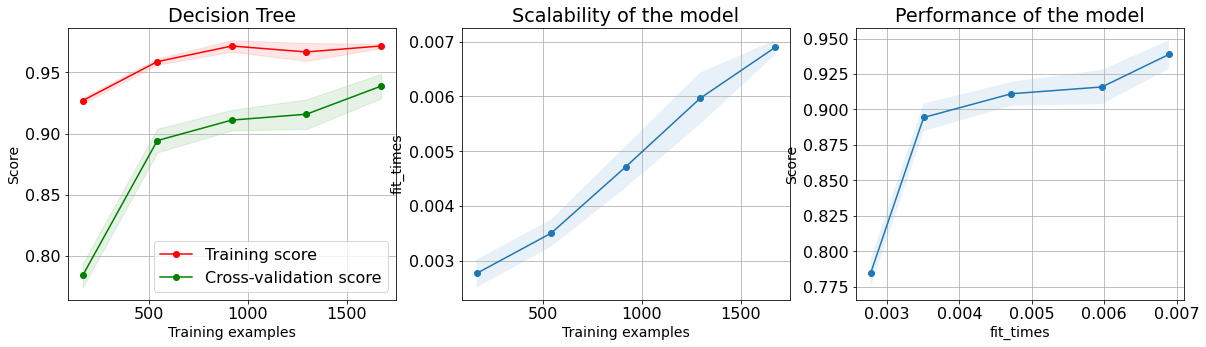

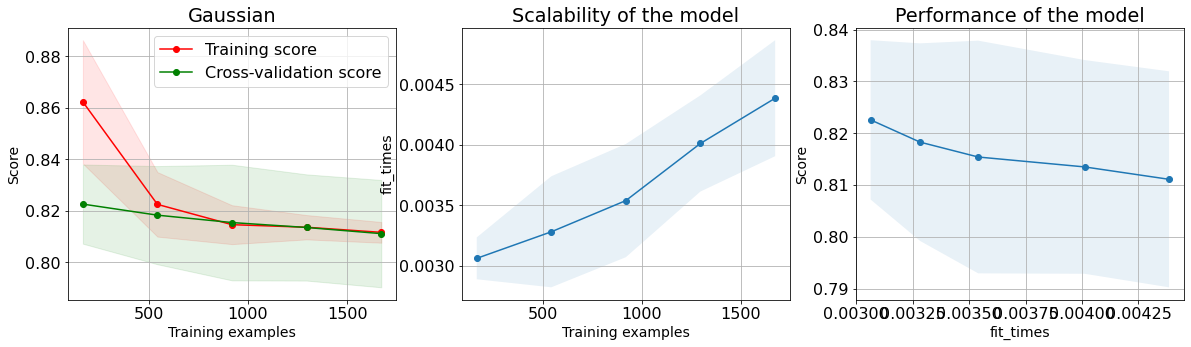

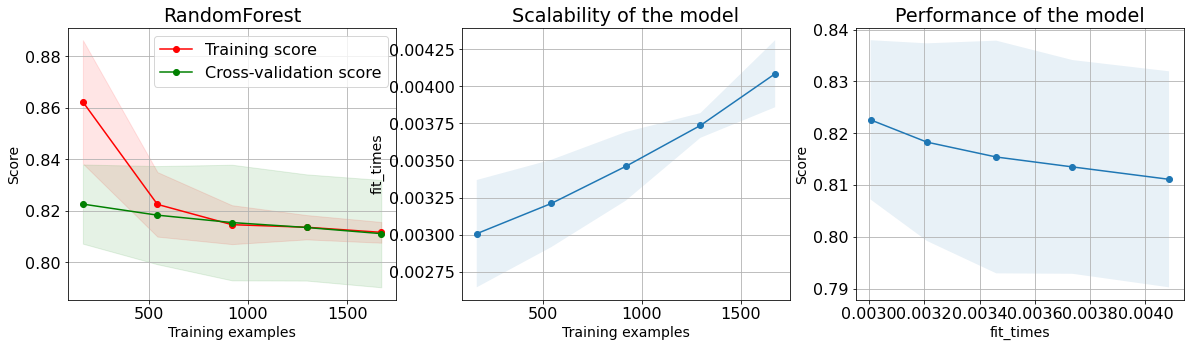

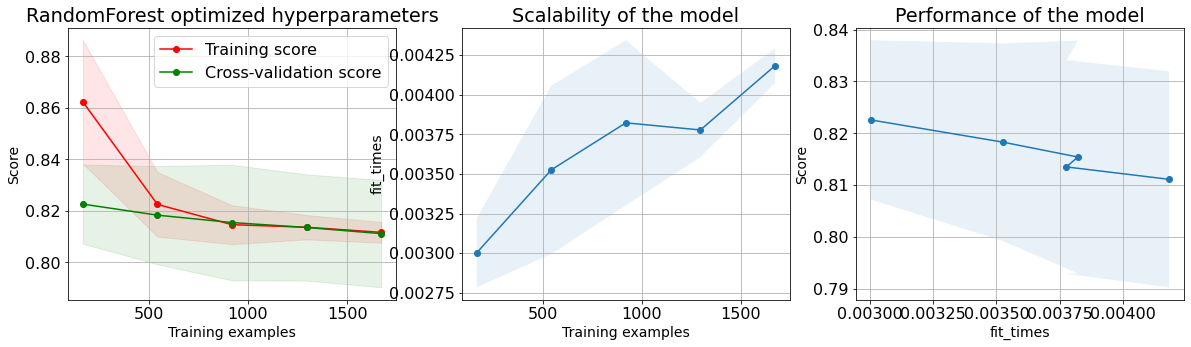

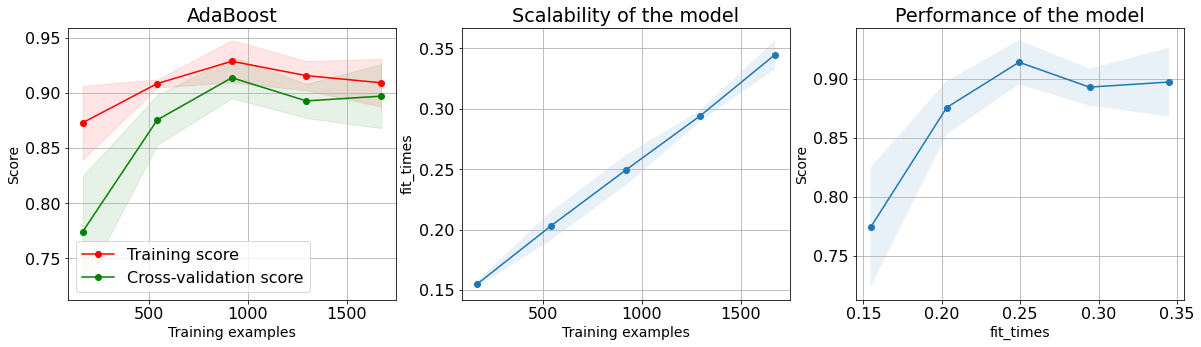

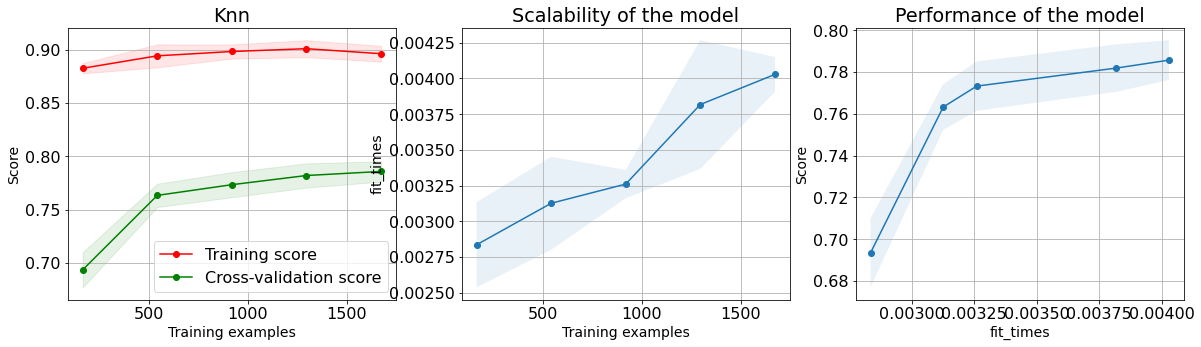

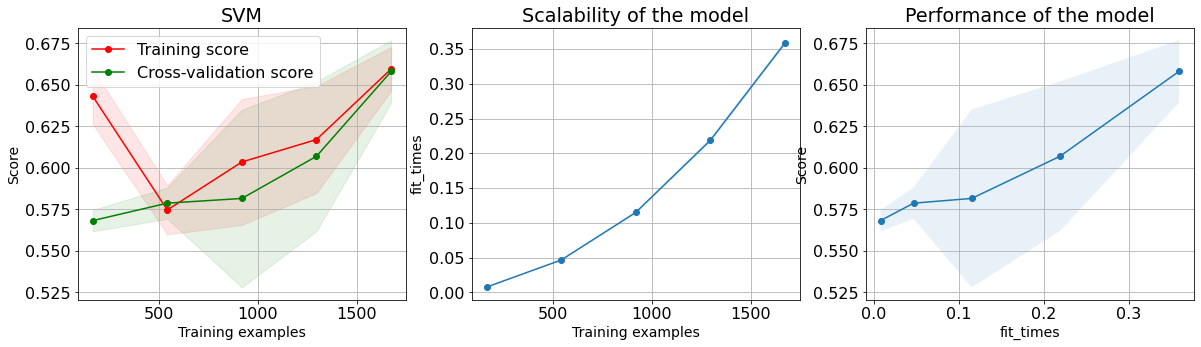

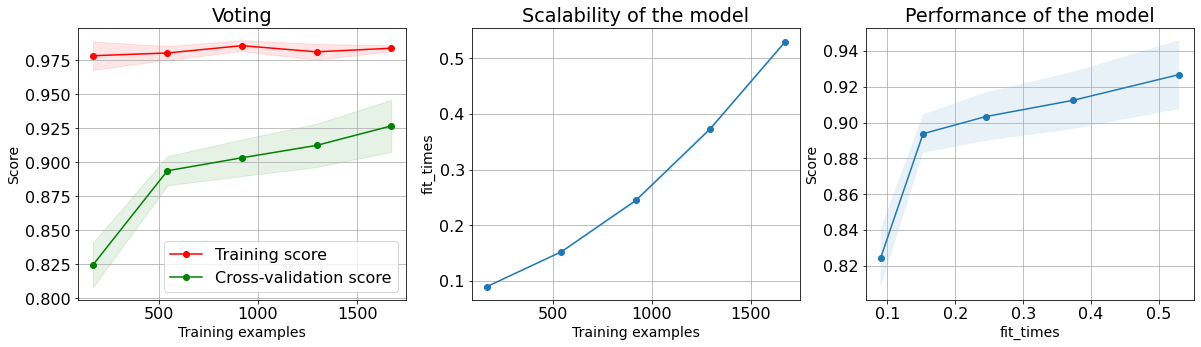

In [34]:
dt_plt = plot_learning_curve(dt,title="Decision Tree",X=train_set,y=train_label)
gnb_plt = plot_learning_curve(gnb,title="Gaussian",X=train_set,y=train_label)
rf_plt = plot_learning_curve(gnb,title="RandomForest",X=train_set,y=train_label)
rf_optimized_plt = plot_learning_curve(gnb,title="RandomForest optimized hyperparameters",X=train_set,y=train_label)
ada_plt = plot_learning_curve(ada,title="AdaBoost",X=train_set,y=train_label)
knn_plt = plot_learning_curve(knn,title="Knn",X=train_set,y=train_label)
svm_plt = plot_learning_curve(svm,title="SVM",X=train_set,y=train_label)
voting_plt = plot_learning_curve(voting,title="Voting",X=train_set,y=train_label)